# Regresión Lineal Bayesiana

En este notebook, implementaremos una regresión lineal bayesiana multivariada. Ejecutaremos el pipeline típico de una tarea de ML: limpieza de datos, exploración de estos para encontrar patrones, establecimiento de un modelo baseline, evaluación de otros modelos y finalmente la implementación de un modelo de regresión lineal bayesiana.

## Dataset

[Datos de UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/student+performance#)

Estamos utilizando datos sobre las calificaciones de estudiantes recopilados en una secundaria portuguesa. Los datos incluyen características académicas y personales de los estudiantes, así como las calificaciones finales.

El objetivo es predecir la calificación final a partir de la información del estudiante, lo que convierte a nuestra tarea en una regresión supervisada. Tenemos un conjunto de datos de entrenamiento con etiquetas conocidas, y queremos que el modelo aprenda una asignación de las características (variables explicativas) al objetivo (la etiqueta), en este caso la calificación final. Se trata de una tarea de regresión porque la calificación final es un valor continuo.

# Imports

In [ ]:
!pip3 install bambi

In [ ]:
!pip3 install pymc

In [3]:
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

from scipy.stats import percentileofscore
from scipy import stats

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

import scipy

In [8]:
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample

import arviz as az
import bambi as bmb

ModuleNotFoundError: No module named 'pymc'

# Exploratory Data Analysis

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Bourbaki/Cursos/Matemáticas para la Ciencia de Datos/student-mat.csv', sep=';')

# Filter out grades that were 0
df = df[~df['G3'].isin([0, 1])]

df = df.rename(columns={'G3': 'Grade'})

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [7]:
df.shape

(357, 33)

### Descripción de las columnas numéricas

In [8]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,16.655462,2.795518,2.546218,1.431373,2.042017,0.271709,3.955182,3.246499,3.098039,1.495798,2.330532,3.549020,6.316527,11.268908,11.358543,11.523810
std,1.268262,1.093999,1.084217,0.686075,0.831895,0.671750,0.885721,1.011601,1.090779,0.919886,1.294974,1.402638,8.187623,3.240450,3.147188,3.227797
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,5.000000,4.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,2.000000,9.000000,9.000000,9.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,14.000000,14.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


### Conteos de las columnas categóricas

In [9]:
# Print the value counts for categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(df[col].value_counts())


Column Name: school
school
GP    315
MS     42
Name: count, dtype: int64

Column Name: sex
sex
F    185
M    172
Name: count, dtype: int64

Column Name: address
address
U    279
R     78
Name: count, dtype: int64

Column Name: famsize
famsize
GT3    250
LE3    107
Name: count, dtype: int64

Column Name: Pstatus
Pstatus
T    318
A     39
Name: count, dtype: int64

Column Name: Mjob
Mjob
other       127
services     94
teacher      54
at_home      50
health       32
Name: count, dtype: int64

Column Name: Fjob
Fjob
other       196
services    100
teacher      26
health       18
at_home      17
Name: count, dtype: int64

Column Name: reason
reason
course        126
reputation     99
home           97
other          35
Name: count, dtype: int64

Column Name: guardian
guardian
mother    248
father     82
other      27
Name: count, dtype: int64

Column Name: schoolsup
schoolsup
no     307
yes     50
Name: count, dtype: int64

Column Name: famsup
famsup
yes    219
no     138
Name: count, dty

### Distribución de las calificaciones (grades)

In [62]:
df['Grade'].describe()

count    357.000000
mean      11.523810
std        3.227797
min        4.000000
25%        9.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: Grade, dtype: float64

In [63]:
df['Grade'].value_counts()

Grade
10    56
11    47
15    33
8     32
13    31
12    31
9     28
14    27
16    16
6     15
18    12
7      9
5      7
17     6
19     5
20     1
4      1
Name: count, dtype: int64

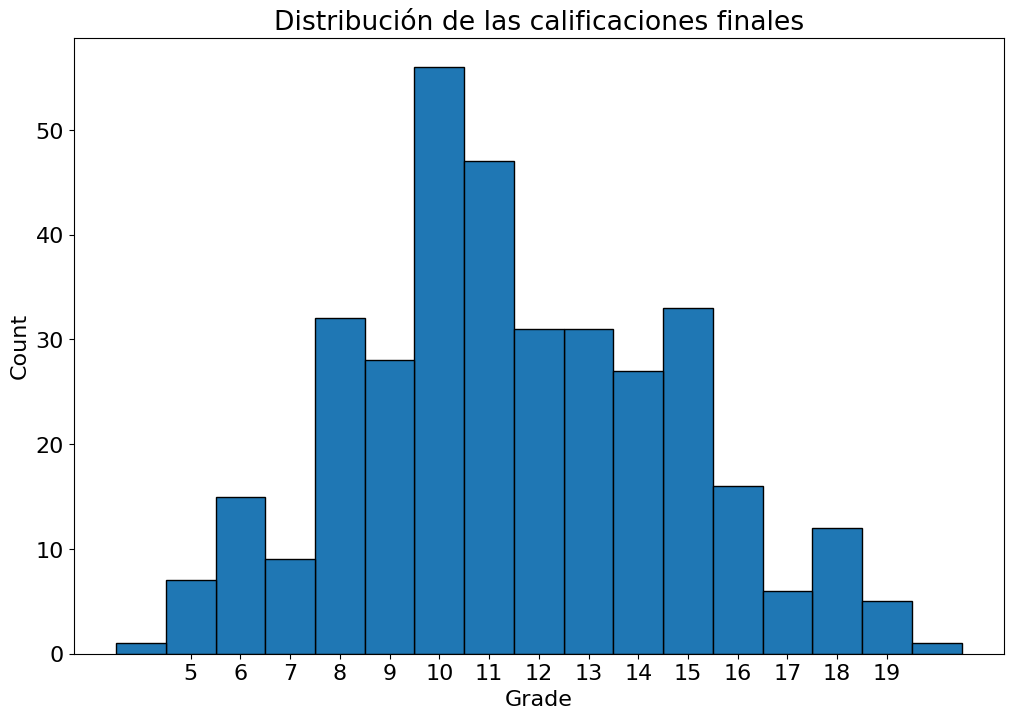

In [64]:
# Bar plot of grades
plt.bar(df['Grade'].value_counts().index,
        df['Grade'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribución de las calificaciones finales');
plt.xticks(list(range(5, 20)));

#### Distribución de calificación según variables categóricas

<ipython-input-69-9d43c6c2bd80>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['address'] == 'U', 'Grade'], label = 'Urban', shade = True)
<ipython-input-69-9d43c6c2bd80>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['address'] == 'R', 'Grade'], label = 'Rural', shade = True)


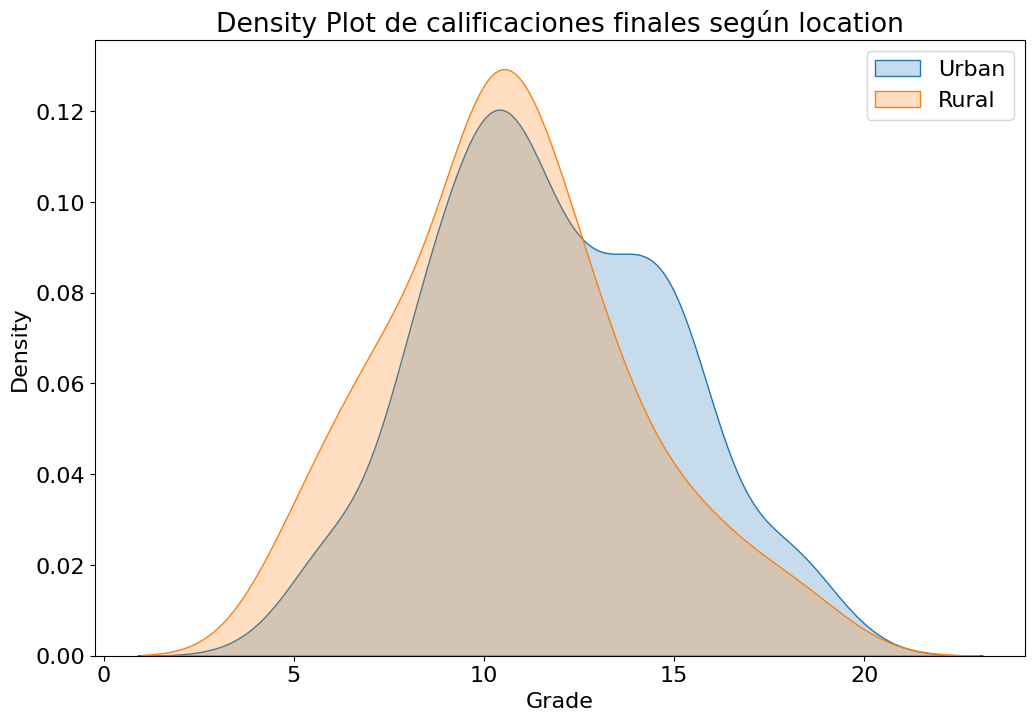

In [69]:
# Grade distribution by address
sns.kdeplot(df.loc[df['address'] == 'U', 'Grade'], label = 'Urban', shade = True)
sns.kdeplot(df.loc[df['address'] == 'R', 'Grade'], label = 'Rural', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot de calificaciones finales según location'); plt.legend();

<ipython-input-70-cb0241fd1bd4>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['guardian'] == 'father', 'Grade'], label = 'Father', shade = True)
<ipython-input-70-cb0241fd1bd4>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['guardian'] == 'mother', 'Grade'], label = 'Mother', shade = True)
<ipython-input-70-cb0241fd1bd4>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['guardian'] == 'other', 'Grade'], label = 'Other', shade = True)


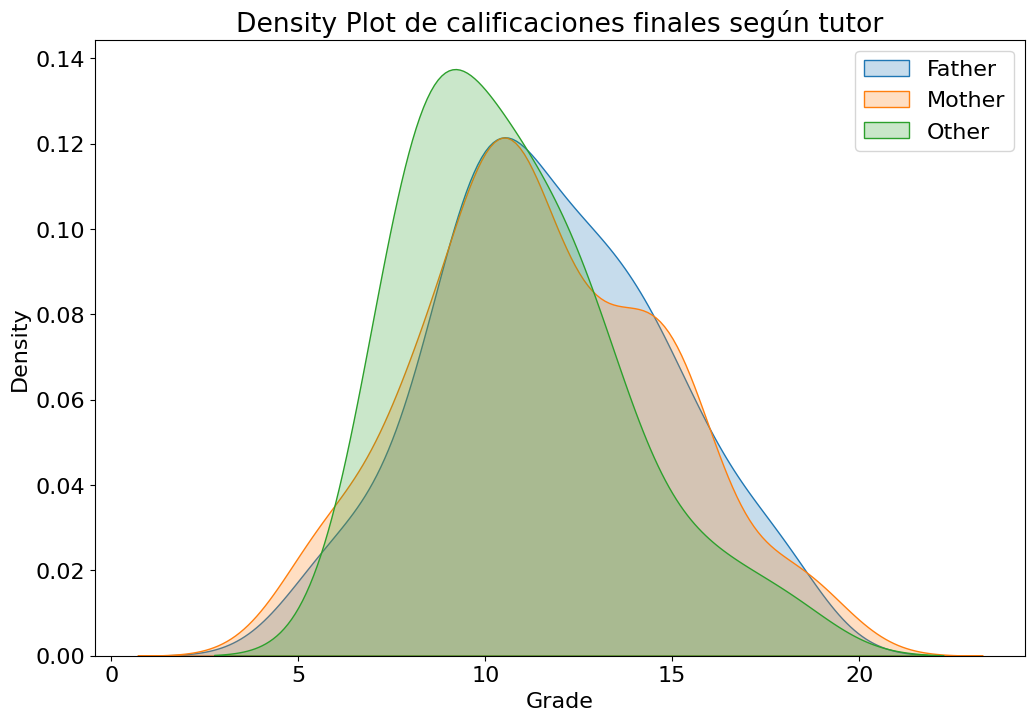

In [70]:
# Grade distribution by Guardian
sns.kdeplot(df.loc[df['guardian'] == 'father', 'Grade'], label = 'Father', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'mother', 'Grade'], label = 'Mother', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'other', 'Grade'], label = 'Other', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot de calificaciones finales según tutor'); plt.legend();

<ipython-input-61-65cd4f28015b>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['internet'] == 'yes', 'Grade'], label = 'Internet', shade = True)
<ipython-input-61-65cd4f28015b>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['internet'] == 'no', 'Grade'], label = 'No Internet', shade = True)


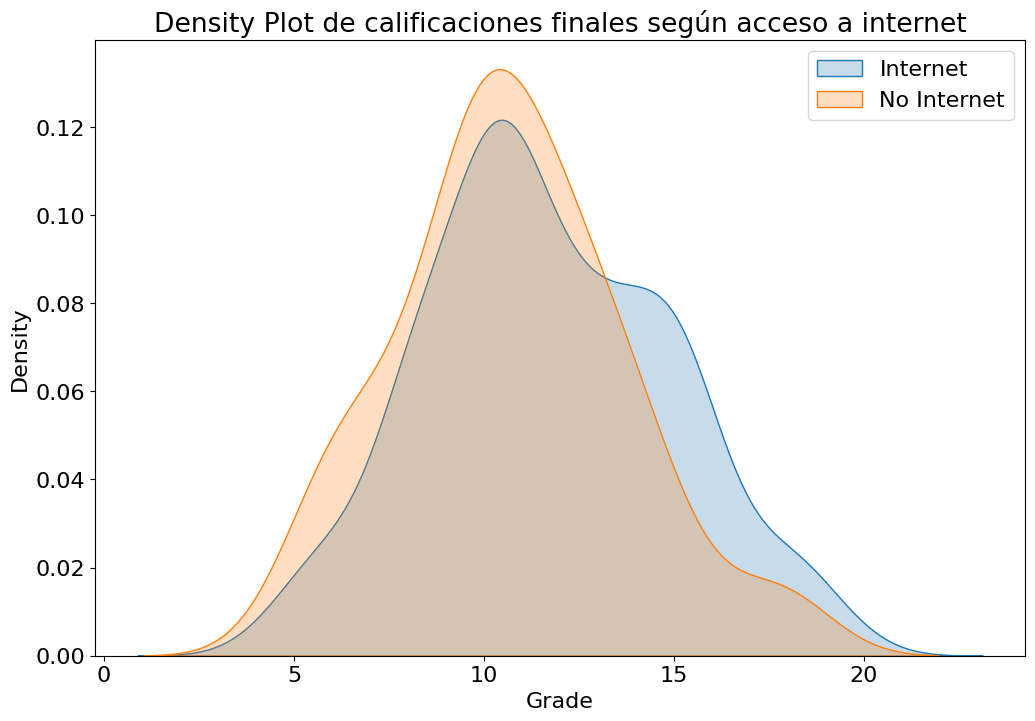

In [61]:
# Grade distribution by internet
sns.kdeplot(df.loc[df['internet'] == 'yes', 'Grade'], label = 'Internet', shade = True)
sns.kdeplot(df.loc[df['internet'] == 'no', 'Grade'], label = 'No Internet', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot de calificaciones finales según acceso a internet'); plt.legend();

<ipython-input-16-64b886a501df>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['school'] == 'GP', 'Grade'], label = 'GP', shade = True)
<ipython-input-16-64b886a501df>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['school'] == 'MS', 'Grade'], label = 'MS', shade = True)


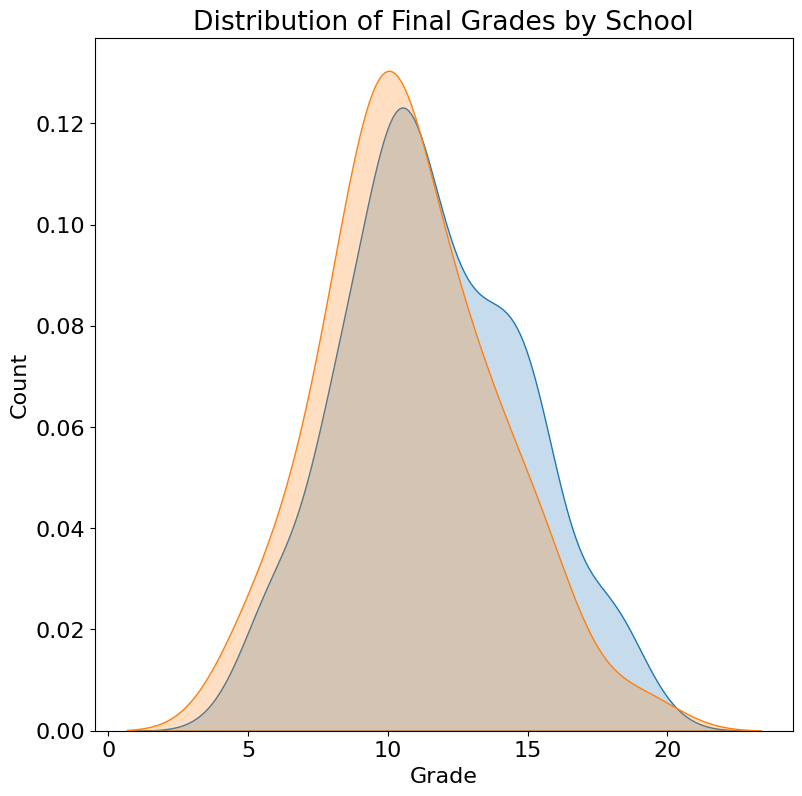

In [16]:
# Grade distribution by school
sns.kdeplot(df.loc[df['school'] == 'GP', 'Grade'], label = 'GP', shade = True)
sns.kdeplot(df.loc[df['school'] == 'MS', 'Grade'], label = 'MS', shade = True)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribution of Final Grades by School');

In [17]:
# Look at distribution of schools by address
schools = df.groupby(['school'])['address'].value_counts()
schools

school  address
GP      U          259
        R           56
MS      R           22
        U           20
Name: count, dtype: int64

### Percentiles de calificaciones

In [18]:
# Calculate percentile for grades
df['percentile'] = df['Grade'].apply(lambda x: percentileofscore(df['Grade'], x))

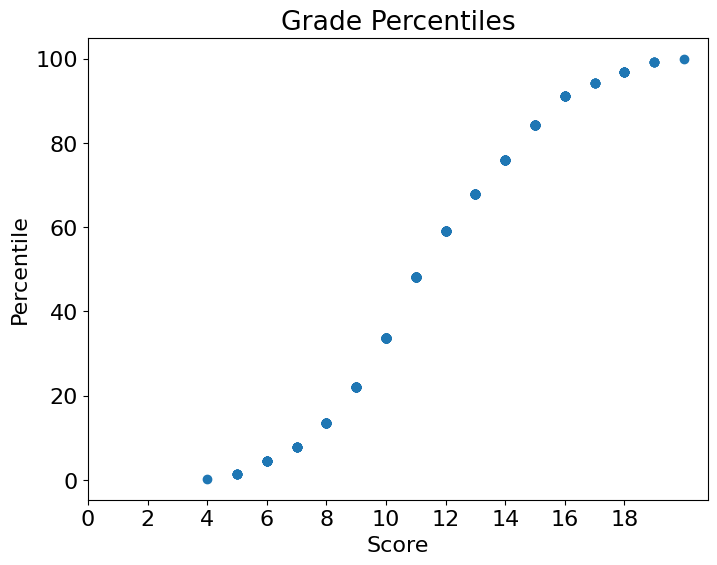

In [19]:
# Plot percentiles for grades
plt.figure(figsize = (8, 6))
plt.plot(df['Grade'], df['percentile'], 'o')
plt.xticks(range(0, 20, 2), range(0, 20, 2))
plt.xlabel('Score'); plt.ylabel('Percentile'); plt.title('Grade percentiles');

In [20]:
print('50th percentile score:', np.min(df.loc[df['percentile'] > 50, 'Grade']))
print('Minimum Score needed for 90th percentile:', np.min(df.loc[df['percentile'] > 90, 'Grade']))

50th percentile score: 12
Minimum Score needed for 90th percentile: 16


# Correlaciones

## Numéricas

In [21]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade,percentile
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,4.481793
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,4.481793
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,33.753501
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,84.313725
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,33.753501


In [22]:
# Correlations of numerical values
df.corr(numeric_only=True)['Grade'].sort_values()

failures     -0.293831
absences     -0.213129
Walc         -0.190054
goout        -0.177383
Dalc         -0.140690
age          -0.140372
traveltime   -0.099785
health       -0.081691
freetime     -0.021589
famrel        0.037711
studytime     0.126728
Fedu          0.158811
Medu          0.190308
G1            0.891805
G2            0.965583
percentile    0.983823
Grade         1.000000
Name: Grade, dtype: float64

## Categóricas (usando One-Hot Encoding)

In [23]:
# Select only categorical variables
category_df = df.select_dtypes('object')
# One hot encode the variables
dummy_df = pd.get_dummies(category_df)
# Put the grade back in the dataframe
dummy_df['Grade'] = df['Grade']
dummy_df.head()

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,Grade
0,True,False,True,False,False,True,True,False,True,False,...,False,False,True,False,True,True,False,True,False,6
1,True,False,True,False,False,True,True,False,False,True,...,False,True,False,False,True,False,True,True,False,6
2,True,False,True,False,False,True,False,True,False,True,...,False,False,True,False,True,False,True,True,False,10
3,True,False,True,False,False,True,True,False,False,True,...,True,False,True,False,True,False,True,False,True,15
4,True,False,True,False,False,True,True,False,False,True,...,False,False,True,False,True,True,False,True,False,10


In [24]:
# Correlations in one-hot encoded dataframe
dummy_df.corr()['Grade'].sort_values()

schoolsup_yes       -0.238365
Mjob_other          -0.142541
address_R           -0.130090
higher_no           -0.113419
internet_no         -0.111624
sex_F               -0.102448
Mjob_at_home        -0.090624
school_MS           -0.083615
Fjob_other          -0.081502
guardian_other      -0.069491
famsup_yes          -0.067305
activities_no       -0.058600
reason_course       -0.050918
romantic_yes        -0.049944
famsize_GT3         -0.039744
paid_yes            -0.028899
Pstatus_T           -0.026665
nursery_no          -0.026541
Fjob_services       -0.018154
reason_other        -0.003897
reason_home          0.000372
Fjob_health          0.006241
guardian_mother      0.007728
nursery_yes          0.026541
Pstatus_A            0.026665
paid_no              0.028899
Fjob_at_home         0.028954
guardian_father      0.035220
famsize_LE3          0.039744
Mjob_teacher         0.045390
romantic_no          0.049944
reason_reputation    0.056573
activities_yes       0.058600
famsup_no 

# Selección de variables más correlacionadas

In [25]:
# Takes in a dataframe, finds the most correlated variables with the
# grade and returns training and testing datasets
def format_data(df):
    # Targets are final grade of student
    labels = df['Grade']

    # Drop the school and the grades from features
    df = df.drop(columns=['school', 'G1', 'G2', 'percentile'])

    # One-Hot Encoding of Categorical Variables
    df = pd.get_dummies(df)

    # Find correlations with the Grade
    most_correlated = df.corr().abs()['Grade'].sort_values(ascending=False)

    # Maintain the top 8 most correlation features with Grade
    most_correlated = most_correlated[:8]

    df = df.loc[:, most_correlated.index]
    df = df.drop(columns = ['schoolsup_no'])

    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels,
                                                        test_size = 0.25,
                                                        random_state=42)

    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = format_data(df)
X_train.head()

,Grade,failures,schoolsup_yes,absences,Medu,Walc,goout
60,11,0,False,6,4,3,4
114,9,0,False,8,2,1,2
281,10,1,False,19,3,4,4
110,19,0,False,6,4,1,3
309,10,1,True,18,1,3,3


In [27]:
# Rename variables in train and test
X_train = X_train.rename(columns={'schoolsup_yes': 'no_higher_edu',
                                  'Medu': 'mother_edu',
                                  'Walc': 'weekend_alcohol',
                                  'goout': 'go_out'})

X_test = X_test.rename(columns={'schoolsup_yes': 'no_higher_edu',
                                  'Medu': 'mother_edu',
                                  'Walc': 'weekend_alcohol',
                                  'goout': 'go_out'})

In [28]:
X_train.head()

,Grade,failures,no_higher_edu,absences,mother_edu,weekend_alcohol,go_out
60,11,0,False,6,4,3,4
114,9,0,False,8,2,1,2
281,10,1,False,19,3,4,4
110,19,0,False,6,4,1,3
309,10,1,True,18,1,3,3


In [29]:
print(X_train.shape)
print(X_test.shape)

(267, 7)
(90, 7)


## Gráficas de scatter, densidad e histogramas

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1550: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(x=data_k, label=label_k, color=color, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1550: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(x=data_k, label=label_k, color=colo

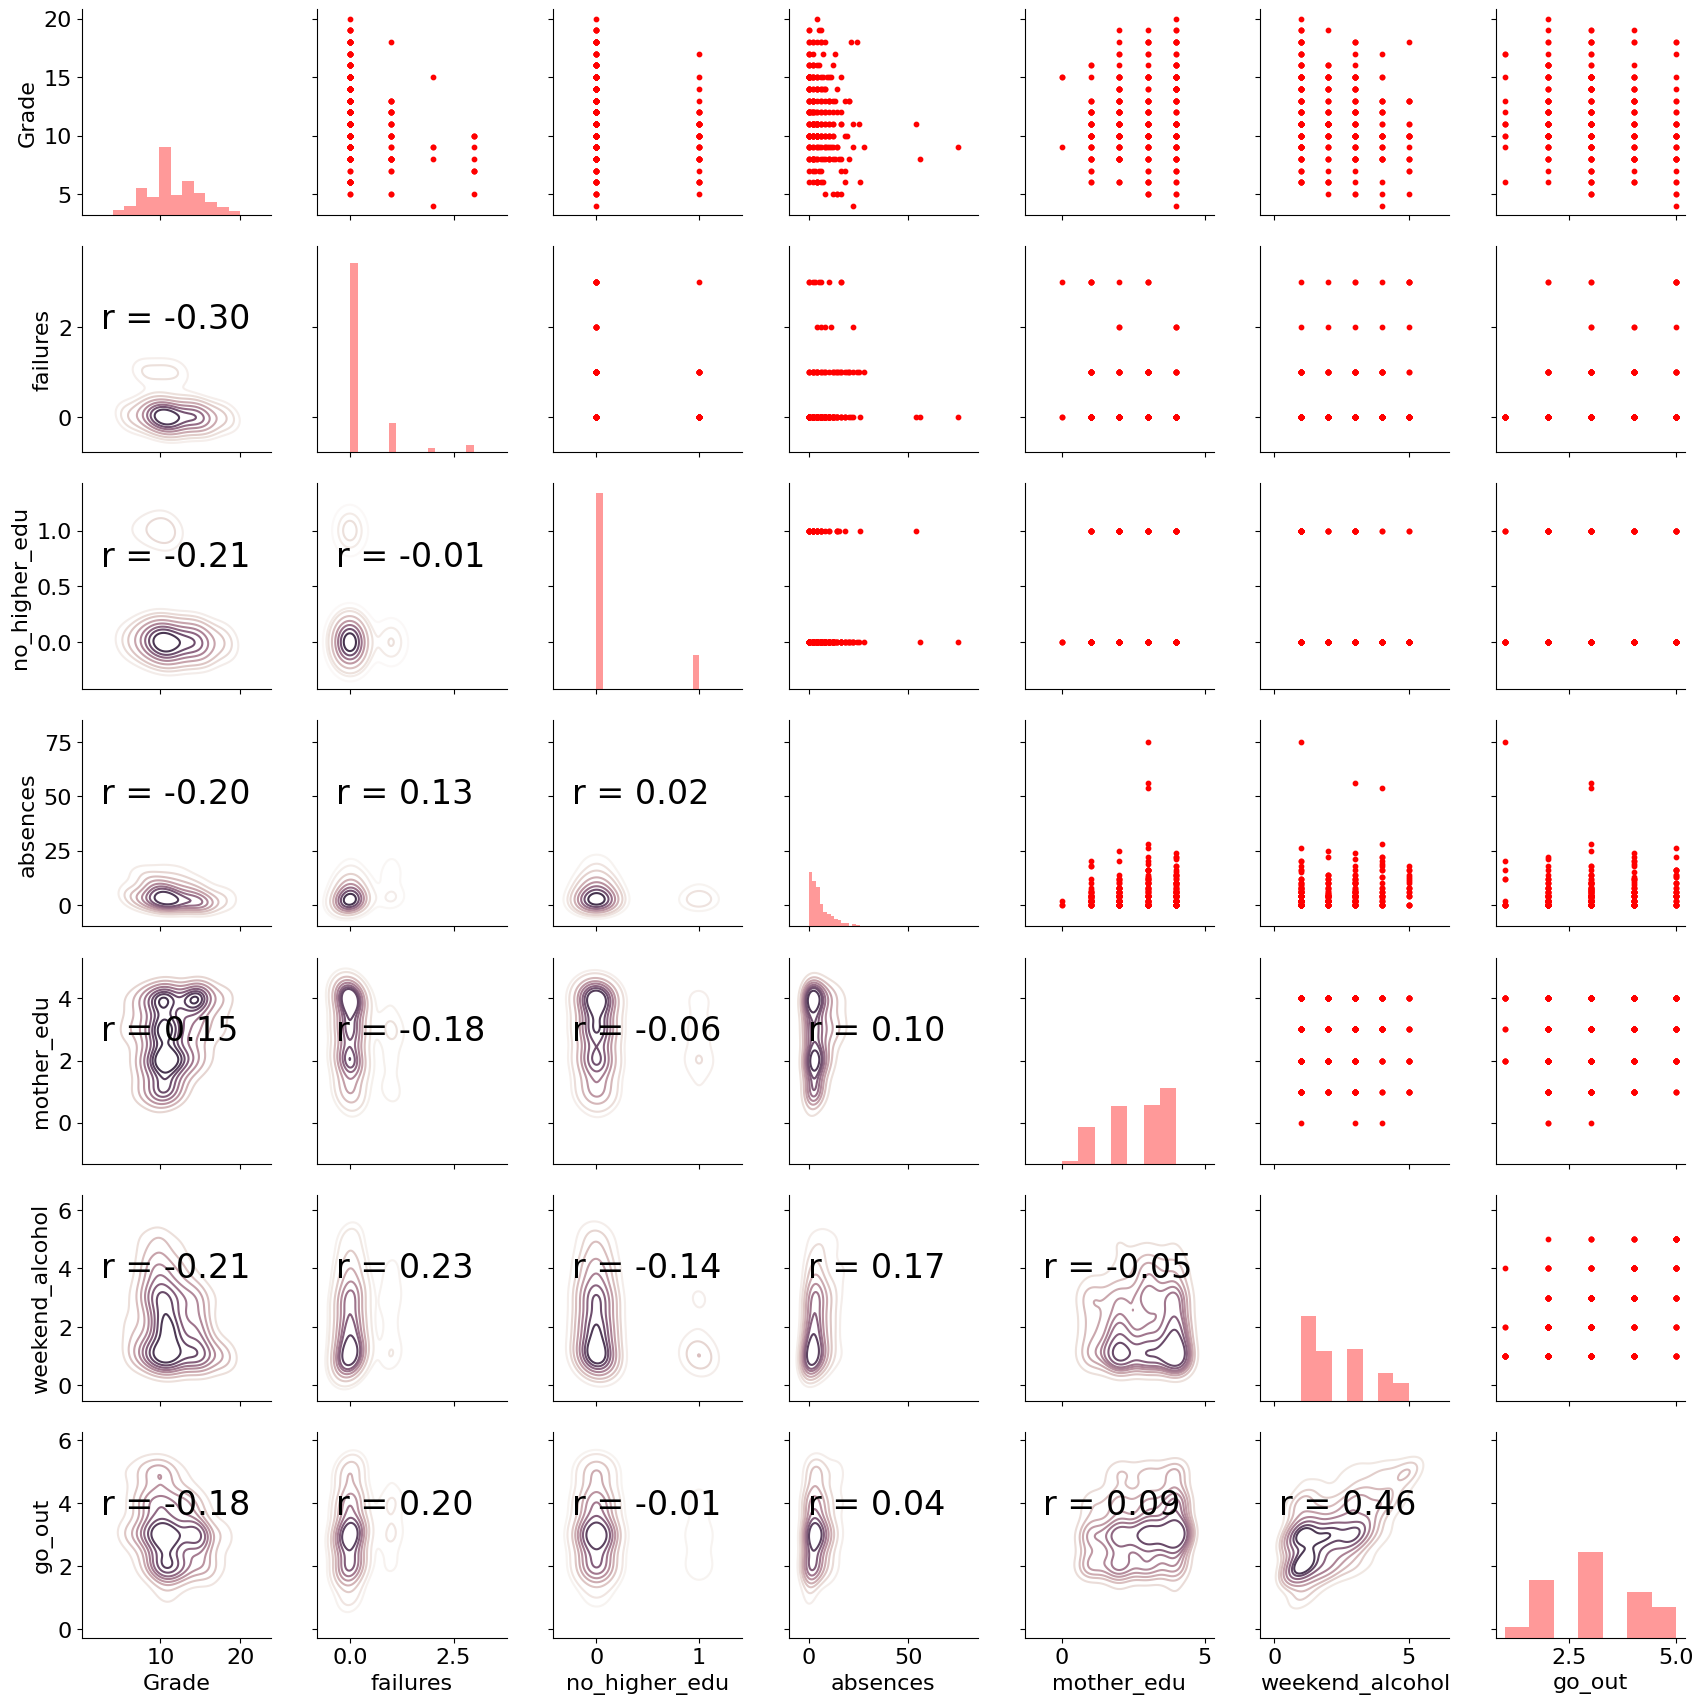

In [30]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)

cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(X_train)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [31]:
# Create relation to the median grade column
X_plot = X_train.copy()
X_plot['relation_median'] = (X_plot['Grade'] >= 12)
X_plot['relation_median'] = X_plot['relation_median'].replace({True: 'above', False: 'below'})
X_plot = X_plot.drop(columns='Grade')

### Distribuciones en relación a la mediana

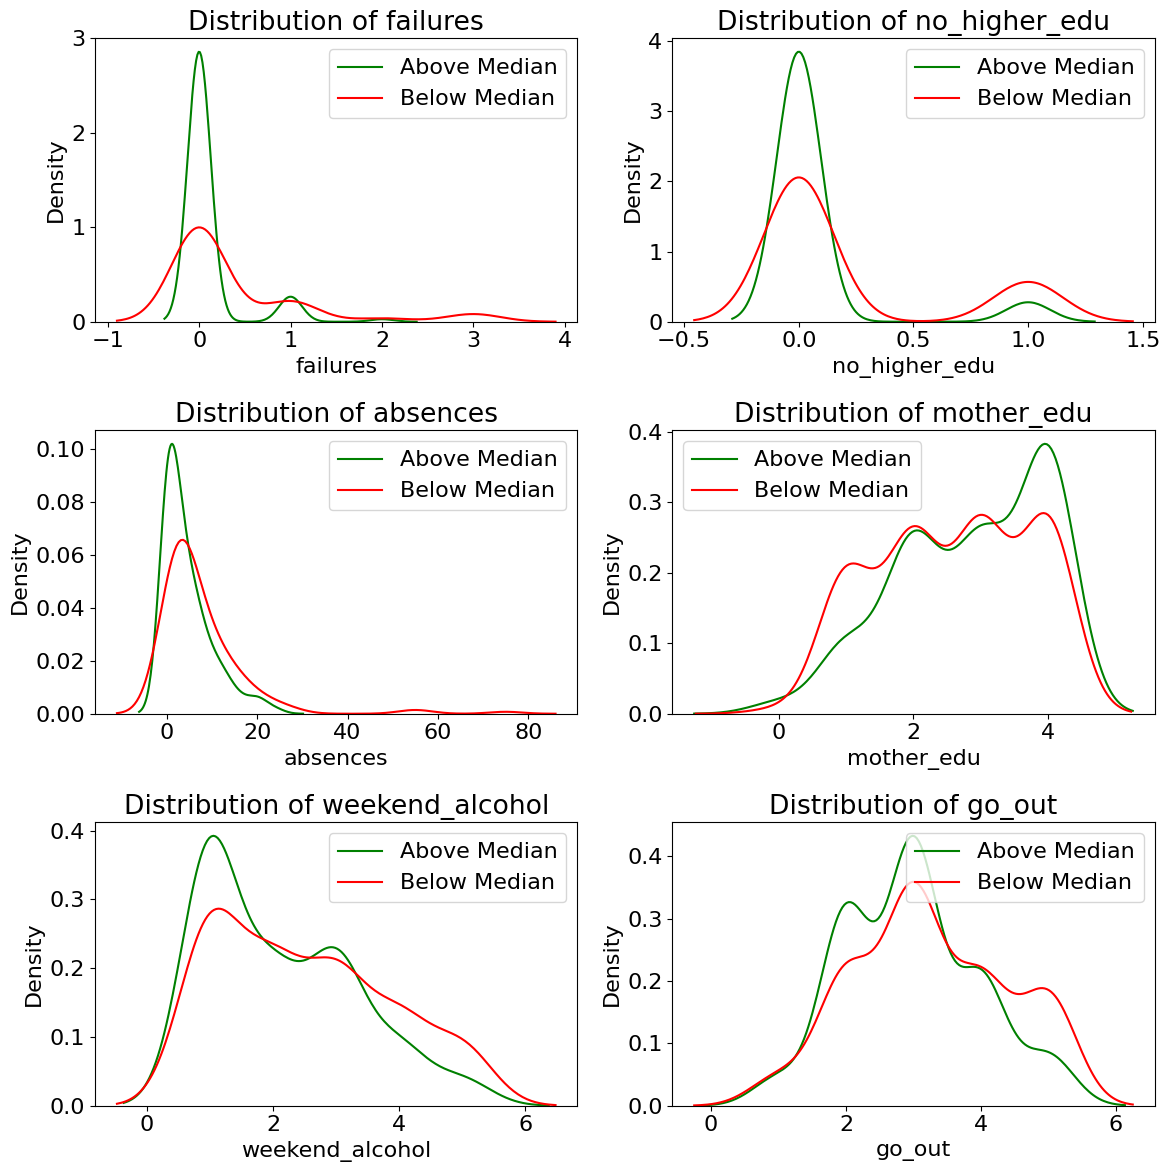

In [32]:
plt.figure(figsize=(12, 12))
# Plot the distribution of each variable colored
# by the relation to the median grade
for i, col in enumerate(X_plot.columns[:-1]):
    plt.subplot(3, 2, i + 1)
    subset_above = X_plot[X_plot['relation_median'] == 'above']
    subset_below = X_plot[X_plot['relation_median'] == 'below']
    sns.kdeplot(subset_above[col], label = 'Above Median', color = 'green')
    sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
    plt.legend(); plt.title('Distribution of %s' % col)

plt.tight_layout()

# Benchmarks

## Métricas

Para esta tarea de regresión, utilizaremos dos métricas estándar:

- Error Absoluto Medio (MAE): Promedio del valor absoluto de la diferencia entre las predicciones y los valores reales.
- Error Cuadrático Medio (RMSE): La raíz cuadrada del promedio de las diferencias cuadradas entre las predicciones y los valores reales.

El error absoluto medio es más interpretable, pero el error cuadrático medio penaliza más severamente los errores grandes.

In [33]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))

    return mae, rmse

### Baseline Ingenuo

Para una tarea de regresión, un baseline sencillo es predecir la mediana del conjunto de entrenamiento en todos los casos de prueba.

In [34]:
# Naive baseline is the median
median_pred = X_train['Grade'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['Grade']

In [35]:
median_pred

11.0

In [36]:
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 2.5556
Median Baseline RMSE: 3.1482


## Algunos modelos de ML

In [37]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='Grade')
    X_test = X_test.drop(columns='Grade')

    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)

    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)

    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))

        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]

    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))

    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]

    return results

In [38]:
results = evaluate(X_train, X_test, y_train, y_test)

#### Comparación de los modelos

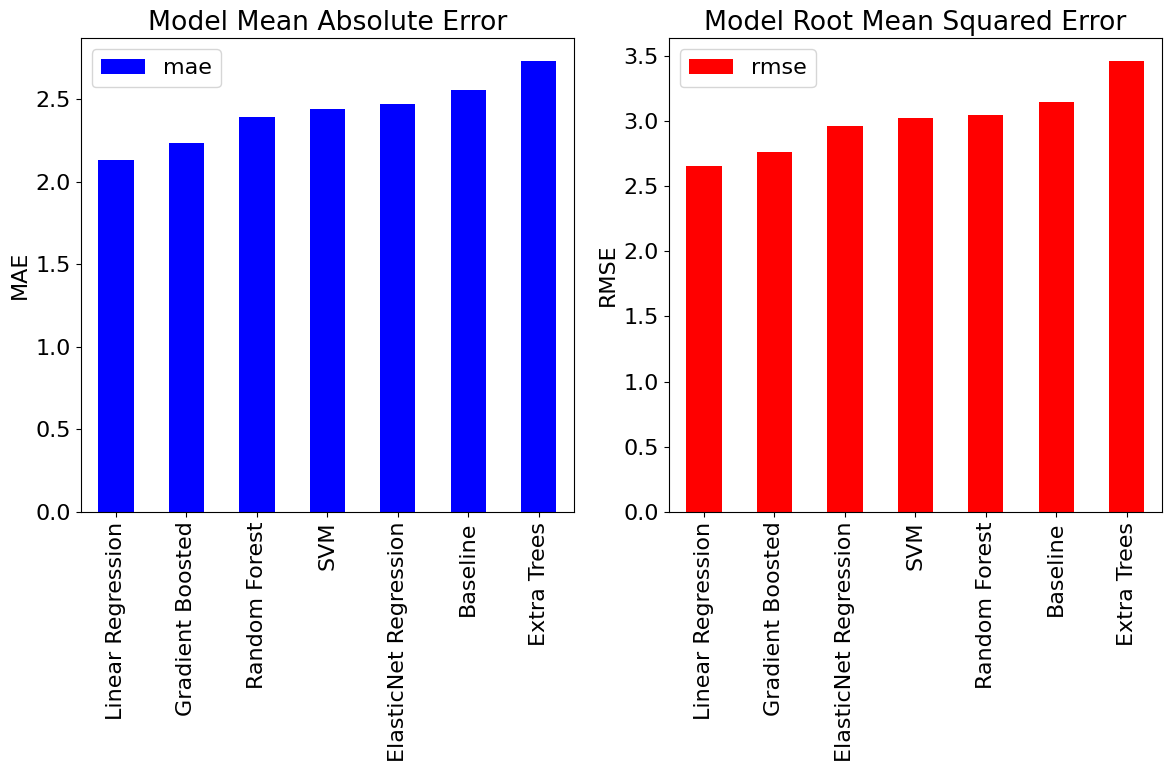

In [39]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

In [40]:
results

,mae,rmse
Linear Regression,2.128675,2.657211
ElasticNet Regression,2.468688,2.965613
Random Forest,2.393545,3.042891
Extra Trees,2.731926,3.462158
SVM,2.442716,3.024263
Gradient Boosted,2.236991,2.765706
Baseline,2.555556,3.148192


In [41]:
print('The Linear Regression is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Linear Regression', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Linear Regression is 16.70% better than the baseline.


## Fórmula de una regresión lineal usual

In [42]:
lr = LinearRegression()
lr.fit(X_train.drop(columns='Grade'), y_train)

ols_formula = 'Grade = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)

' '.join(ols_formula.split(' ')[:-1])

'Grade = 13.04 + -1.04 * failures + -2.03 * no_higher_edu + -0.06 * absences + 0.36 * mother_edu + -0.29 * weekend_alcohol + -0.28 * go_out'

# Regresiones lineales con Bambi (Bayesian Model Building Interface)

Recordemos cómo se ve una regresión lineal usual. La visión frecuentista de la regresión lineal supone que los datos se generan a partir del siguiente modelo:

$ y = \beta X + \epsilon$

Donde la respuesta, y, se genera a partir de los parámetros del modelo, β, multiplicados por la matriz de entrada, X, más el error debido al ruido de muestreo aleatorio o las variables latentes.

In [43]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

In [44]:
data

,x,y
0,0.000000,1.386850
1,0.005025,0.740979
2,0.010050,0.346761
3,0.015075,0.589855
4,0.020101,0.474925
...,...,...
195,0.979899,3.374182
196,0.984925,2.977421
197,0.989950,3.200937
198,0.994975,3.513960


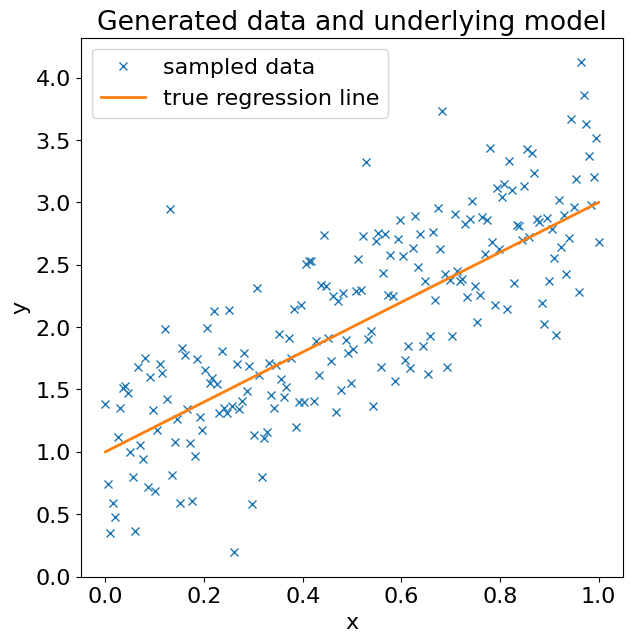

In [45]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [46]:
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=3000)

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


# Implementando una regresión lineal Bayesiana

La Regresión Lineal Bayesiana supone que las respuestas se muestrean a partir de una distribución de probabilidad, como la distribución normal (Gaussiana).

$\ y \sim N(\beta X, \sigma^2)$

La media de la distribución Gaussiana es el producto de los parámetros β y las entradas X, y la desviación estándar es σ.

En los modelos bayesianos, no solo se supone que la respuesta se extrae de una distribución, sino también los parámetros. El objetivo es determinar la distribución de probabilidad posterior para los parámetros del modelo dados los datos de entrada, X, y los valores de salida, y.

$P(\beta | y, X) = \frac{P(y | \beta, X) P(\beta | X)}{P(y | X)}$

Si tenemos algún conocimiento del dominio, podemos utilizarlo para asignar priores a los parámetros del modelo, o podemos usar priores no informativos: distribuciones con desviaciones estándar grandes que no asumen nada sobre la variable. Utilizar un prior no informativo significa que "dejamos que los datos hablen". Una elección común de prior es usar una distribución normal para β y una distribución half-Cauchy para σ.

En la práctica, calcular la distribución posterior exacta para valores continuos es computacionalmente inviable. Por eso, recurrimos a métodos de muestreo como Markov Chain Monte Carlo (MCMC) para extraer muestras del posterior y así aproximarlo.

Monte Carlo se refiere a la técnica general de extraer muestras aleatorias.
Cadena de Markov significa que el siguiente valor de la muestra extraída se basa únicamente en el valor de la muestra anterior.
En esencia, MCMC crea una "cadena" de muestras que "camina" a través del espacio de parámetros, explorando regiones de alta probabilidad en la distribución posterior.

In [48]:
# Formula for Bayesian Linear Regression (follows R formula syntax)
formula = 'Grade ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'Grade ~ failures + no_higher_edu + absences + mother_edu + weekend_alcohol + go_out'

In [49]:
model = bmb.Model(formula, X_train)
idata = model.fit(draws=2000)

Output()

Output()

In [50]:
normal_trace = idata

# Examinando nuestros resultados

## Traceplot

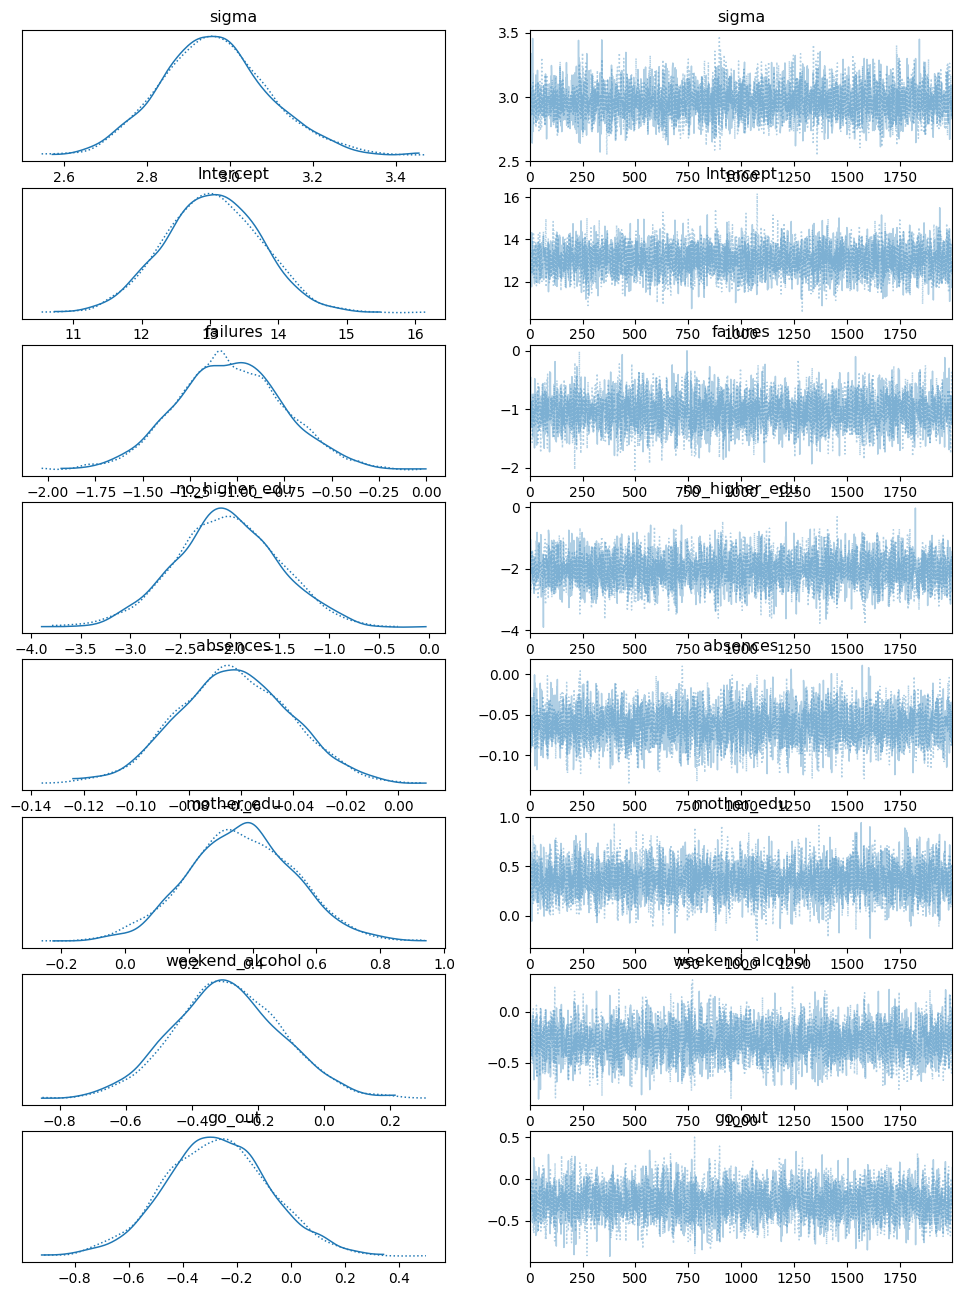

In [51]:
pm.plot_trace(normal_trace);

El lado izquierdo del traceplot representa la distribución marginal posterior: los valores de la variable están en el eje x y la probabilidad de la variable (determinada mediante muestreo) está en el eje y. Las líneas de diferentes colores indican que realizamos dos cadenas de Monte Carlo Marcov. En el lado izquierdo podemos ver que hay un rango de valores para cada peso. El lado derecho muestra los diferentes valores de muestra extraídos a medida que se ejecuta el proceso de muestreo.

Otro método integrado en PyMC y arviz para examinar los resultados del trace es el diagrama forestal (forestplot), que muestra la distribución de cada parámetro muestreado. Esto nos permite ver la incertidumbre en cada muestra. El diagrama forestal se construye fácilmente:

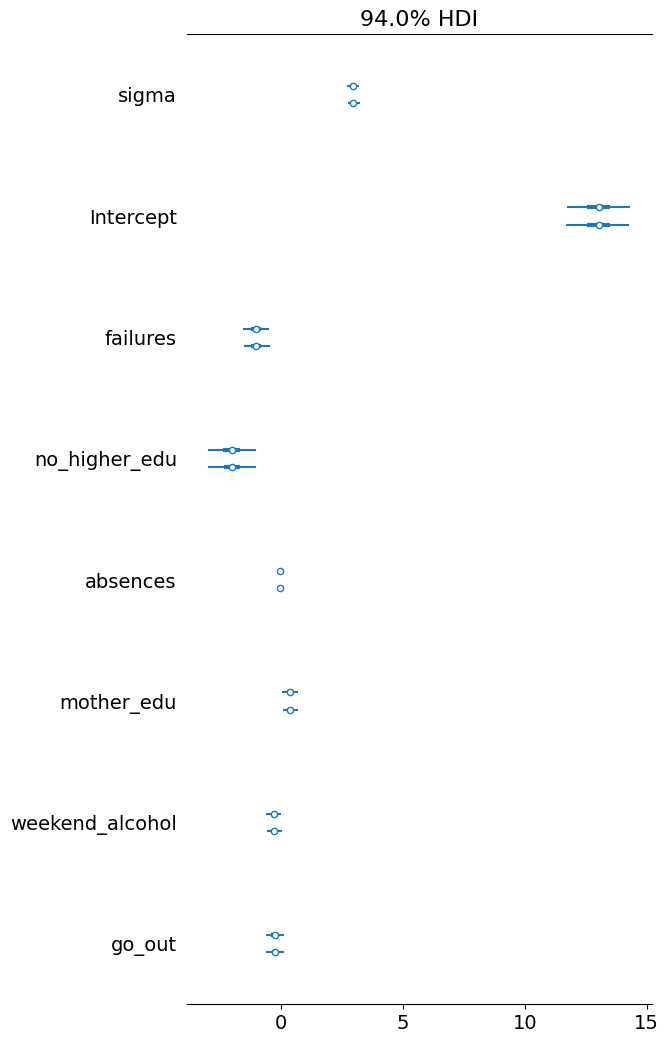

In [52]:
az.plot_forest(normal_trace);

Finalmente, también podemos plottear el posterior para cada uno de los parámetros:

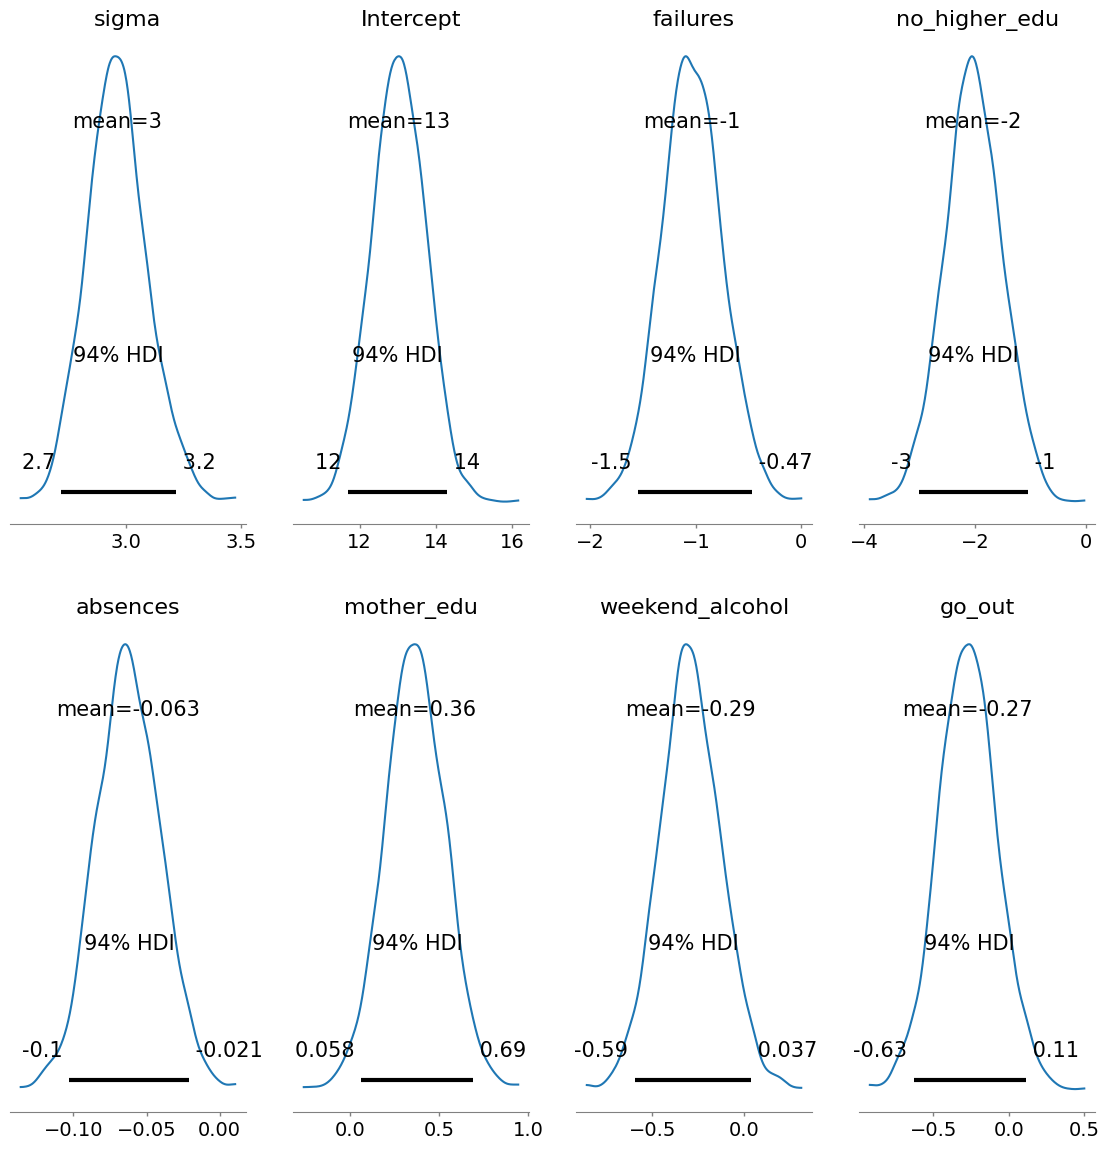

In [53]:
pm.plot_posterior(normal_trace, figsize = (14, 14));

## Interpretaciones de los parámetros

De acuerdo al signo y la ubicación de los pesos (coeficientes), podemos inferir lo siguiente acerca de las características en nuestro conjunto de datos:

- Los fracasos previos en cursos están relacionados negativamente con las calificaciones finales de los estudiantes. (Peso negativo)
- Mayores ambiciones educativas están relacionadas positivamente con las calificaciones de los estudiantes. (Peso positivo)
- El nivel educativo de la madre está relacionado positivamente con las calificaciones finales de los estudiantes. (Peso positivo para ambos)
- El consumo de alcohol durante el fin de semana está relacionado negativamente con las calificaciones finales de los estudiantes. (Peso negativo)
- La frecuencia de salidas está relacionada negativamente con las calificaciones finales de los estudiantes. (Peso negativo)

In [54]:
az.summary(normal_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,2.964,0.131,2.722,3.218,0.002,0.001,4919.0,2877.0,1.0
Intercept,13.031,0.701,11.689,14.288,0.009,0.007,5495.0,3474.0,1.0
failures,-1.037,0.286,-1.545,-0.471,0.004,0.003,4582.0,3083.0,1.0
no_higher_edu,-2.030,0.518,-3.009,-1.044,0.007,0.006,4902.0,3022.0,1.0
absences,-0.063,0.022,-0.103,-0.021,0.000,0.000,4119.0,3103.0,1.0
mother_edu,0.364,0.169,0.058,0.692,0.002,0.002,4818.0,3553.0,1.0
weekend_alcohol,-0.292,0.167,-0.594,0.037,0.002,0.002,4464.0,3409.0,1.0
go_out,-0.272,0.194,-0.629,0.111,0.003,0.002,4042.0,3230.0,1.0


### Fórmula lineal a partir de inferencia bayesiana (utilizando la media de los parámetros)

In [55]:
model_formula = 'Grade = '
for variable in normal_trace.posterior.data_vars:
  if variable not in ['sigma', 'Intercept']:
    #print(variable)
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace.posterior[variable]), variable)

    ' '.join(model_formula.split(' ')[:-1])

model_formula

'Grade =  -1.04 * failures + -2.03 * no_higher_edu + -0.06 * absences + 0.36 * mother_edu + -0.29 * weekend_alcohol + -0.27 * go_out +'

# Siguientes pasos: elección de otros priors

Podemos realizar exactamente el mismo Modelado Lineal Bayesiano utilizando una distribución T de Student como previa para la verosimilitud de los datos. La distribución T de Student tiene más peso en las colas de la distribución, por lo que es más robusta a valores atípicos (outliers).

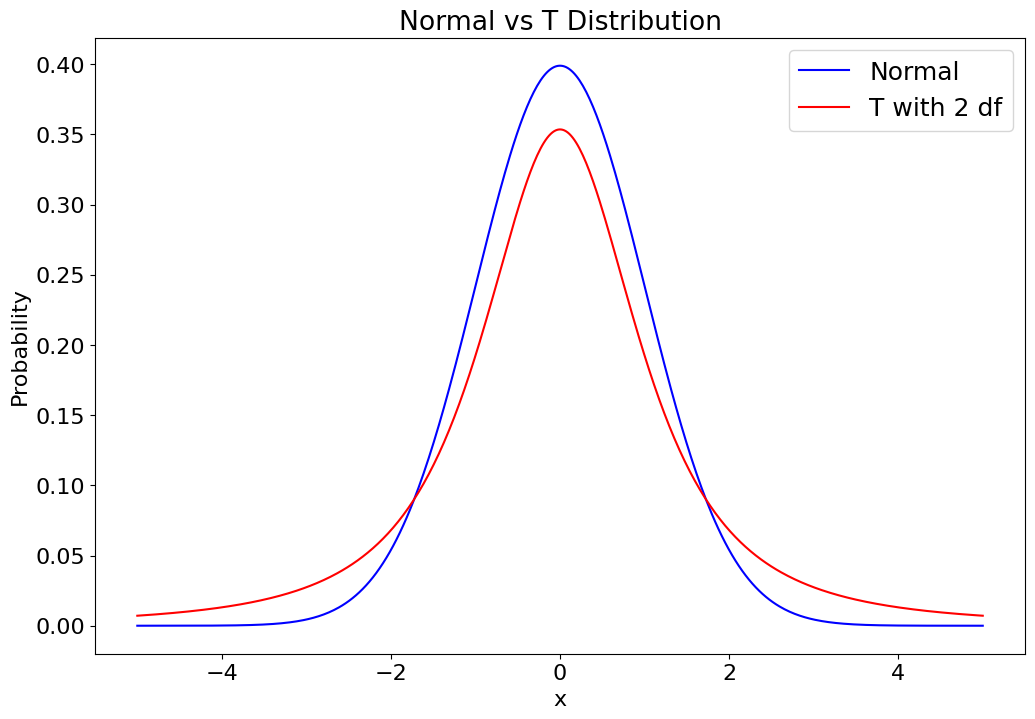

In [56]:
# X values for plotting
x = np.linspace(-5, 5, num = 500)

# Generate pdf of normal distribution
y_norm = scipy.stats.norm.pdf(x)

# PDF of t-distribution with 2 degrees of freedom
y_t = scipy.stats.t.pdf(x, df = 2)

plt.plot(x, y_norm, 'b-', label = 'Normal')
plt.plot(x, y_t, 'r-', label = 'T with 2 df')
plt.legend(prop = {'size': 18}, loc = 1)
plt.xlabel('x'); plt.ylabel('Probability'); plt.title('Normal vs T Distribution');

# Conclusiones


Para esta tarea de regresión (con pocos datos), y además de los modelos estándar de aprendizaje automático que aprenden de las observaciones, utilizamos la Regresión Lineal Bayesiana para crear un modelo que mapea las features (características de los estudiantes) a los targets (calificación final).

Las ventajas de la Regresión Lineal Bayesiana son que, si usamos priors razonables, aún podemos obtener una estimación decente con pocas muestras, y los pesos finales no son un número único, sino una distribución compuesta por cada muestra extraída durante la ejecución del muestreo. Entonces podemos hacer predicciones usando todos los pesos muestreados para formar una distribución de valores esperados en lugar de una única respuesta.